[INFO] Using exported model: /Users/imalsky/Desktop/Chemulator/models/big/export_k1_cpu.pt2  | device=cpu dtype=float32
[INFO] Input species (12): ['C2H2_evolution', 'CH4_evolution', 'CO2_evolution', 'CO_evolution', 'H2O_evolution', 'H2_evolution', 'HCN_evolution', 'H_evolution', 'N2_evolution', 'NH3_evolution', 'OH_evolution', 'O_evolution']
[INFO] T0=1e+06  T_FINAL=1e+08  DT_STEP=1e+06
[INFO] ZERO_REPLACE=1.000e-15  ZERO_EPS=0.000e+00
[INFO] VULCAN: /Users/imalsky/Desktop/Chemistry_Project/Vulcan/0D_full_NCHO/solar/vul-T1000KlogP3.0-NCHO-solar_hot_ini.vul

[DEBUG] Inferred per-species training floor (physical):
    C2H2: 1.000000e-30
     CH4: 1.000000e-30
     CO2: 1.000004e-30
      CO: 1.000000e-30
     H2O: 1.000000e-30
      H2: 1.000000e-30
     HCN: 1.000000e-30
       H: 1.000000e-30
      N2: 1.000000e-30
     NH3: 1.000000e-30
      OH: 1.000000e-30
       O: 1.000000e-30

[DEBUG] dt normalization: method='log-min-max'  range=[0.001, 1e+08]  source=fallback-grid (1e-3..1e8)

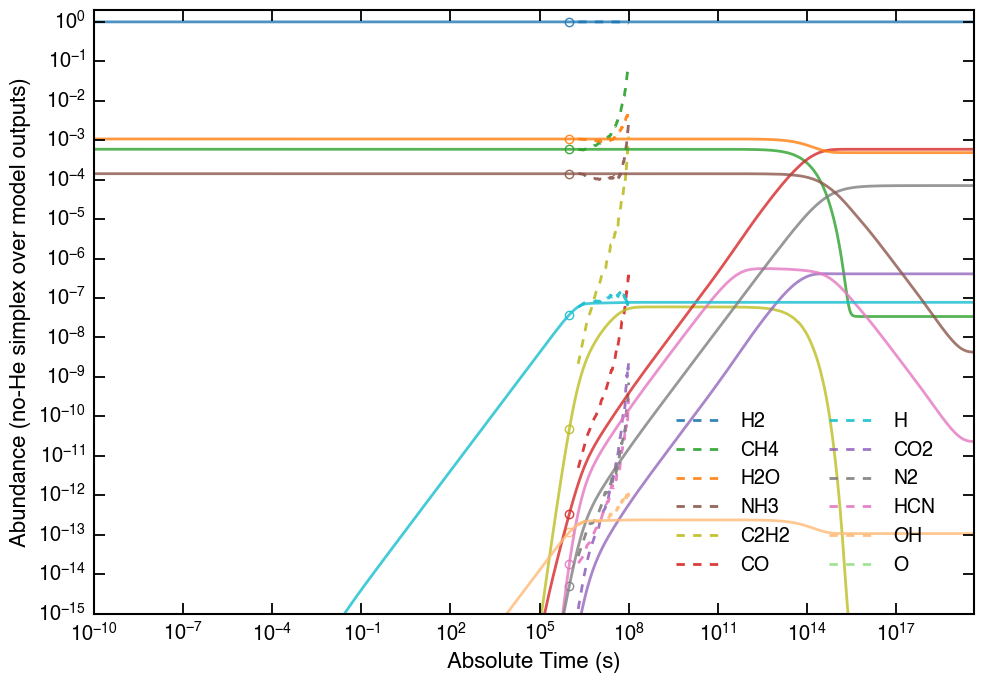

In [4]:
#!/usr/bin/env python3
"""
Autoregressive K=1 runner with robust Δt normalization and safe denormalization.

- Δt(sec) → dt_norm uses manifest stats if present; else a fallback grid (1e-3..1e8).
- Per-species training floors (inferred) enforced at anchor and each AR step.
- Safe denormalization clamps to [epsilon, clamp_value] and scrubs NaNs/Infs.
- Globals printed (phys vs eff norm→denorm).
- Model outputs plotted after renormalizing over model outputs (same as VULCAN overlay).
"""

from __future__ import annotations
import math, json, warnings, sys
from pathlib import Path
from typing import Dict, List, Tuple

import numpy as np
import torch
import matplotlib.pyplot as plt
import pickle

plt.style.use('science.mplstyle')

# ===================== HARD-CODED CONFIG =====================

# Paths
REPO_ROOT     = Path("/Users/imalsky/Desktop/Chemulator")
MODEL_DIR     = REPO_ROOT / "models" / "big"              # expects export_k1_cpu.pt2
PROCESSED_DIR = REPO_ROOT / "data" / "processed"
SRC_DIR       = REPO_ROOT / "src"
VULCAN_PATH   = Path("/Users/imalsky/Desktop/Chemistry_Project/Vulcan/0D_full_NCHO/solar/vul-T1000KlogP3.0-NCHO-solar_hot_ini.vul")

# Timing (absolute seconds)
T0       = 1.0e6         # start time
T_FINAL  = 1.0e8         # end time
DT_STEP  = 1.0e6         # fixed step size

# Zero policy layered on top of training floors (optional)
ZERO_REPLACE = 1.0e-15   # None to disable; if v <= ZERO_EPS, set to this and renorm
ZERO_EPS     = 0.0

# Globals (P in barye, T in K)
T_K  = 1000.0
P_Pa = 100.0
P_barye = P_Pa * 10.0

# Visuals
PLOT_FLOOR = 1e-30
PLOT_PREF = ['H2','H2O','CH4','CO','CO2','NH3','HCN','N2','C2H2','H','CH3','OH','O']

# ===================== Repo imports =====================

if str(SRC_DIR) not in sys.path:
    sys.path.append(str(SRC_DIR))
from normalizer import NormalizationHelper  # type: ignore

# ===================== IO helpers =====================

def _read_json(p: Path) -> Dict:
    with p.open("r", encoding="utf-8") as f:
        return json.load(f)

def _load_norm() -> NormalizationHelper:
    man_path = PROCESSED_DIR / "normalization.json"
    if not man_path.exists():
        raise FileNotFoundError(f"Missing {man_path}")
    return NormalizationHelper(_read_json(man_path))

def _get_meta_lists(norm: NormalizationHelper) -> Tuple[List[str], List[str], List[str]]:
    manifest = getattr(norm, "manifest", {})
    meta = manifest.get("meta", {}) if isinstance(manifest, dict) else {}
    in_names: List[str] = list(meta.get("species_variables") or manifest.get("species_variables") or [])
    if not in_names:
        raise RuntimeError("species_variables not found in normalization manifest.")
    in_bases = [n[:-10] if n.endswith("_evolution") else n for n in in_names]
    gvars: List[str] = list(meta.get("global_variables") or manifest.get("global_variables") or [])
    if not gvars:
        raise RuntimeError("global_variables not found in normalization manifest.")
    return in_names, in_bases, gvars

def _find_export_artifact(model_dir: Path) -> Path:
    for name in ("export_k1_cpu.pt2", "export_k1.pt2", "complete_model_exported_k1.pt2", "complete_model_exported.pt2"):
        p = model_dir / name
        if p.exists():
            return p
    raise FileNotFoundError(f"No exported model found in {model_dir} (expected export_k1_cpu.pt2).")

# ===================== Domain helpers =====================

def _load_vulcan(vulcan_path: Path):
    if not vulcan_path.exists():
        raise FileNotFoundError(f"VULCAN file not found: {vulcan_path}")
    with open(vulcan_path, "rb") as h:
        d = pickle.load(h)
    t = np.asarray(d["variable"]["t_time"], dtype=float)   # [T] absolute seconds
    Y = np.asarray(d["variable"]["y_time"], dtype=float)   # [T, layer, S]
    names = list(d["variable"]["species"])
    den = np.maximum(Y[:,0,:].sum(axis=-1), 1e-30)         # total incl. He
    MR  = Y[:,0,:] / den[:,None]                           # mixing ratios (incl. He in denom)
    return {"t": t, "MR": MR, "names": names}

def _sample_vulcan_at_time(vul: Dict, t_abs: float) -> Tuple[int, float, Dict[str,float]]:
    """Return (index, t_samp, {species: abundance}) nearest to absolute time t_abs."""
    t = vul["t"]
    idx = int(np.clip(np.argmin(np.abs(t - t_abs)), 0, len(t)-1))
    t_samp = float(t[idx])
    vec = {name: float(vul["MR"][idx, j]) for j, name in enumerate(vul["names"])}
    return idx, t_samp, vec

def _map_vulcan_to_inputs(in_bases: List[str], vul_vec: Dict[str, float]) -> np.ndarray:
    return np.array([max(vul_vec.get(b, 0.0), 0.0) for b in in_bases], dtype=np.float64)

def infer_training_floor(norm: NormalizationHelper, var_names: List[str]) -> np.ndarray:
    """Infer per-species physical floors implied by training (0 → normalize → denormalize)."""
    z = torch.zeros(1, len(var_names), dtype=torch.float32)
    eff = norm.denormalize(norm.normalize(z, var_names), var_names).numpy().reshape(-1)
    eff = np.nan_to_num(eff, nan=0.0, posinf=0.0, neginf=0.0)
    eff = np.maximum(eff, 1e-30)
    return eff.astype(np.float64)

def project_to_training_simplex(vec_phys: np.ndarray,
                                floor_vec: np.ndarray,
                                zero_replace: float | None,
                                zero_eps: float,
                                context: str = "") -> np.ndarray:
    """
    Project a physical vector to the training simplex (sum=1):
      - nan/inf -> 0; negatives -> 0
      - per-species floor: max(vec, floor_vec)
      - renormalize to sum=1
      - optional ZERO_REPLACE for entries <= zero_eps, then renormalize again
    """
    v = np.nan_to_num(vec_phys, nan=0.0, posinf=0.0, neginf=0.0).astype(np.float64, copy=False)
    v = np.maximum(v, floor_vec)
    s = float(v.sum())
    if not np.isfinite(s) or s <= 0:
        warnings.warn(f"{context}: sum<=0 after training-floor clamp; using uniform fallback.", RuntimeWarning)
        v = np.full_like(v, 1.0 / len(v))
    else:
        v /= s
    if zero_replace is not None:
        mask = (v <= zero_eps)
        if np.any(mask):
            v[mask] = zero_replace
            s = float(v.sum())
            if not np.isfinite(s) or s <= 0:
                warnings.warn(f"{context}: sum<=0 after ZERO_REPLACE; using uniform fallback.", RuntimeWarning)
                v = np.full_like(v, 1.0 / len(v))
            else:
                v /= s
    return v.astype(np.float32)

# ---------- dt normalization ----------

DT_GRID_FALLBACK = np.array([
  0.00000000e+00, 1.00000005e-03, 1.29492581e-03, 1.67683291e-03, 2.17137439e-03,
  2.81176879e-03, 3.64103192e-03, 4.71486617e-03, 6.10540248e-03, 7.90604297e-03,
  1.02377394e-02, 1.32571133e-02, 1.71669796e-02, 2.22299639e-02, 2.87861563e-02,
  3.72759365e-02, 4.82695736e-02, 6.25055209e-02, 8.09400156e-02, 1.04811311e-01,
  1.35722876e-01, 1.75751060e-01, 2.27584586e-01, 2.94705182e-01, 3.81621331e-01,
  4.94171321e-01, 6.39915228e-01, 8.28642786e-01, 1.07303095e+00, 1.38949549e+00,
  1.79929364e+00, 2.32995176e+00, 3.01711488e+00, 3.90693998e+00, 5.05919743e+00,
  6.55128574e+00, 8.48342896e+00, 1.09854116e+01, 1.42252932e+01, 1.84207001e+01,
  2.38534393e+01, 3.08884354e+01, 3.99982338e+01, 5.17947464e+01, 6.70703583e+01,
  8.68511353e+01, 1.12465782e+02, 1.45634842e+02, 1.88586334e+02, 2.44205307e+02,
  3.16227753e+02, 4.09491516e+02, 5.30261108e+02, 6.86648865e+02, 8.89159363e+02,
  1.15139539e+03, 1.49097168e+03, 1.93069775e+03, 2.50011035e+03, 3.23745752e+03,
  4.19226758e+03, 5.42867529e+03, 7.02973193e+03, 9.10298145e+03, 1.17876865e+04,
  1.52641797e+04, 1.97659805e+04, 2.55954785e+04, 3.31442461e+04, 4.29193438e+04,
  5.55773672e+04, 7.19685703e+04, 9.31939609e+04, 1.20679266e+05, 1.56270703e+05,
  2.02358969e+05, 2.62039859e+05, 3.39322188e+05, 4.39397062e+05, 5.68986625e+05,
  7.36795438e+05, 9.54095500e+05, 1.23548288e+06, 1.59985875e+06, 2.07169838e+06,
  2.68269575e+06, 3.47389200e+06, 4.49843250e+06, 5.82513650e+06, 7.54312000e+06,
  9.76778100e+06, 1.26485520e+07, 1.63789370e+07, 2.12095080e+07, 2.74647420e+07,
  3.55648040e+07, 4.60537840e+07, 5.96362320e+07, 7.72244960e+07, 1.00000000e+08
], dtype=np.float64)

def _get_norm_method(manifest: Dict, key: str, default: str = "log-min-max") -> str:
    nm = (manifest.get("normalization") or {})
    methods = (nm.get("methods") or {})
    return str(methods.get(key, nm.get("default_method", default))).lower()

def _get_stats_range_or_fallback(manifest: Dict, key: str) -> Tuple[float, float, bool]:
    """Return (min,max,used_fallback). If stats missing for 'dt', use the grid 1e-3..1e8."""
    stats = (manifest.get("stats") or {})
    if key in stats and "min" in stats[key] and "max" in stats[key]:
        mn = float(stats[key]["min"])
        mx = float(stats[key]["max"])
        return mn, mx, False
    if key == "dt":
        grid = DT_GRID_FALLBACK[DT_GRID_FALLBACK > 0]  # drop 0 for log
        return float(grid.min()), float(grid.max()), True
    raise KeyError(f"No stats range for '{key}' in manifest. Found: {list(stats.keys())}")

def dt_phys_to_hat(dt_phys: np.ndarray, manifest: Dict) -> Tuple[np.ndarray, Dict[str, float]]:
    """Δt (s) → dt_norm ∈[0,1] via method & stats (with fallback); clips and reports clipping."""
    dt_phys = np.asarray(dt_phys, dtype=np.float64)
    method = _get_norm_method(manifest, "dt", default="log-min-max")
    dmin, dmax, used_fallback = _get_stats_range_or_fallback(manifest, "dt")
    if not np.isfinite(dmin) or not np.isfinite(dmax) or dmax <= dmin:
        raise ValueError(f"Bad dt range: min={dmin}, max={dmax}")

    n_below = int(np.sum(dt_phys < dmin))
    n_above = int(np.sum(dt_phys > dmax))
    dt_clip = np.clip(dt_phys, dmin, dmax)

    if "log" in method:
        a = math.log(dmin); b = math.log(dmax)
        hat = (np.log(dt_clip) - a) / (b - a)
    elif "min-max" in method:
        hat = (dt_clip - dmin) / (dmax - dmin)
    else:
        raise RuntimeError(f"Unsupported dt normalization method: '{method}'")

    info = {"dt_method": method, "dt_min": dmin, "dt_max": dmax,
            "clipped_low": n_below, "clipped_high": n_above,
            "used_fallback_stats": used_fallback}
    return hat.astype(np.float32), info

# ===================== Torch + safe denorm =====================

@torch.inference_mode()
def _predict_k1(fn,
                y_norm: torch.Tensor,
                g_norm: torch.Tensor,
                dt_hat_scalar: torch.Tensor) -> torch.Tensor:
    """
    Call exported program (y, dt_norm, g).

    Expected shapes to satisfy torch.export constraints:
      y_norm       [B, S_in]
      dt_hat_scalar[1] or [B]  -> we reshape to [B, 1]
      g_norm       [B, G]

    Returns [B, S_out] (normalized).
    """
    # Make dt_norm rank-2: [B,1]. For B=1 this becomes [1,1].
    dt_b1 = dt_hat_scalar.reshape(-1, 1)

    out = fn(y_norm, dt_b1, g_norm)
    return out if isinstance(out, torch.Tensor) else torch.as_tensor(out)


def safe_denorm(norm: NormalizationHelper,
                y_norm: torch.Tensor,
                names: List[str],
                manifest: Dict) -> np.ndarray:
    """
    Denormalize and clamp to a sane physical range using manifest:
    - epsilon: lower bound (default 1e-30)
    - clamp_value: upper bound (default 1e10)
    Also scrubs NaN/Inf to [epsilon, clamp_value].
    """
    arr = norm.denormalize(y_norm, names).cpu().numpy().reshape(-1)
    eps = float((manifest.get("normalization") or {}).get("epsilon", 1e-30))
    clamp_val = float((manifest.get("normalization") or {}).get("clamp_value", 1e10))
    arr = np.nan_to_num(arr, nan=eps, posinf=clamp_val, neginf=eps)
    arr = np.clip(arr, eps, clamp_val)
    return arr

# ===================== Main =====================

def main() -> None:
    # ---- Load normalization + lists ----
    norm = _load_norm()
    manifest: Dict = getattr(norm, "manifest", {})
    in_names, in_bases, gvars = _get_meta_lists(norm)

    # ---- Load exported program ----
    art = _find_export_artifact(MODEL_DIR)
    from torch.export import load as torch_export_load
    ep = torch_export_load(str(art))
    fn = ep.module()

    device = torch.device("cpu")
    dtype  = torch.float32

    print(f"[INFO] Using exported model: {art}  | device={device.type} dtype={str(dtype).replace('torch.','')}")
    print(f"[INFO] Input species ({len(in_names)}): {in_names}")
    print(f"[INFO] T0={T0:g}  T_FINAL={T_FINAL:g}  DT_STEP={DT_STEP:g}")
    zr = 'None' if ZERO_REPLACE is None else f'{ZERO_REPLACE:.3e}'
    print(f"[INFO] ZERO_REPLACE={zr}  ZERO_EPS={ZERO_EPS:.3e}")
    print(f"[INFO] VULCAN: {VULCAN_PATH}")

    # ---- Training floors (per species, physical) ----
    train_floor_in = infer_training_floor(norm, in_names)  # aligned to in_names order
    print("\n[DEBUG] Inferred per-species training floor (physical):")
    for b, v in zip(in_bases, train_floor_in):
        print(f"  {b:>6s}: {float(v):.6e}")

    # ---- dt method + stats (with fallback) ----
    method = _get_norm_method(manifest, "dt", default="log-min-max")
    dmin, dmax, used_fallback = _get_stats_range_or_fallback(manifest, "dt")
    src = "fallback-grid (1e-3..1e8)" if used_fallback else "manifest.stats"
    print(f"\n[DEBUG] dt normalization: method='{method}'  range=[{dmin:.6g}, {dmax:.6g}]  source={src}")

    # ---- Build anchor from VULCAN @ T0 → project to training simplex ----
    vul = _load_vulcan(VULCAN_PATH)
    _, t_samp, raw_vul = _sample_vulcan_at_time(vul, T0)
    print(f"\n[DEBUG] VULCAN nearest to T0: t≈{t_samp:.6g} s")
    print("[DEBUG] Raw VULCAN @T0 (incl.-He denom):")
    for b in in_bases:
        print(f"  {b:>6s}: {float(raw_vul.get(b, 0.0)):.6e}")

    y0_inputs_phys_raw = _map_vulcan_to_inputs(in_bases, raw_vul)             # [S_in]
    y0_train_simplex   = project_to_training_simplex(y0_inputs_phys_raw,
                                                     floor_vec=train_floor_in,
                                                     zero_replace=ZERO_REPLACE,
                                                     zero_eps=ZERO_EPS,
                                                     context="anchor")
    print("\n[DEBUG] Anchor AFTER training-floor projection (fed to model, before norm):")
    for b, v in zip(in_bases, y0_train_simplex):
        print(f"  {b:>6s}: {float(v):.6e}")
    print(f"[DEBUG] Sum(anchor projected) = {float(y0_train_simplex.sum()):.6e}")

    # Prove the clamp: norm→denorm should be ~identity now
    y0_eff = norm.denormalize(norm.normalize(torch.from_numpy(y0_train_simplex.reshape(1,-1)), in_names),
                              in_names).numpy().reshape(-1)
    print(f"[DEBUG] max|anchor - eff(norm→denorm)| = {np.max(np.abs(y0_eff - y0_train_simplex)):.3e}")

    # ---- Globals vector ----
    g = np.zeros((1, len(gvars)), dtype=np.float32)
    for i, name in enumerate(gvars):
        n = name.strip().lower()
        g[0, i] = P_barye if n.startswith("p") else (T_K if n.startswith("t") else 0.0)

    # Print globals eff and any stats if present
    g_norm_chk = norm.normalize(torch.from_numpy(g), gvars)
    g_eff  = norm.denormalize(g_norm_chk, gvars).numpy().reshape(-1)
    print("\n[DEBUG] Globals (phys vs eff(norm→denorm)):")
    stats = manifest.get("stats", {})
    for name, phys, eff in zip(gvars, g[0], g_eff):
        rg = stats.get(name, {})
        print(f"  {name:>2s}: phys={phys:.6g}  eff={eff:.6g}  stats={rg}")

    # ---- Prepare tensors on the correct device/dtype ----
    y_curr = norm.normalize(torch.from_numpy(y0_train_simplex.reshape(1, -1)), in_names).to(device=device, dtype=dtype)
    g_t    = norm.normalize(torch.from_numpy(g), gvars).to(device=device, dtype=dtype)

    # ---- Probe output size and names ----
    dt_hat_probe_np, _ = dt_phys_to_hat(np.array([DT_STEP], dtype=np.float64), manifest)
    dt_probe_hat = torch.from_numpy(dt_hat_probe_np).to(device=device, dtype=dtype)
    probe = _predict_k1(fn, y_curr, g_t, dt_probe_hat)   # [1,S_out]
    S_out = int(probe.shape[-1])

    meta_block = (manifest.get("meta") or {})
    cand_targets = list(meta_block.get("target_species_variables") or manifest.get("target_species_variables") or [])
    out_names = cand_targets if (cand_targets and len(cand_targets) == S_out) else (in_names if len(in_names) == S_out else in_names[:S_out])
    out_bases = [n[:-10] if n.endswith("_evolution") else n for n in out_names]
    print(f"\n[INFO] Output size S_out={S_out}; using names: {out_names}")

    # ---- Build mappings between outputs and inputs ----
    in_idx_by_base  = {b: i for i, b in enumerate(in_bases)}
    out_idx_by_base = {b: i for i, b in enumerate(out_bases)}
    missing = [b for b in out_bases if b not in in_idx_by_base]
    if missing:
        raise RuntimeError(f"Output species missing from inputs; cannot autoregress: {missing}")

    # ---- Autoregressive rollout ----
    if not (T_FINAL > T0 and DT_STEP > 0):
        raise ValueError("Require T_FINAL > T0 and DT_STEP > 0.")

    n_steps = int(math.ceil((T_FINAL - T0) / DT_STEP))
    times_abs = np.empty(n_steps, dtype=np.float64)
    y_phys_out_all = np.empty((n_steps, S_out), dtype=np.float64)

    current_time = T0
    dt_norm_vals: List[float] = []
    clipped_low = 0
    clipped_high = 0

    for k in range(n_steps):
        dt_k = min(DT_STEP, T_FINAL - current_time)
        # Δt → dt_norm (clipped)
        dt_hat_np, info = dt_phys_to_hat(np.array([dt_k], dtype=np.float64), manifest)
        dt_norm_vals.append(float(dt_hat_np[0]))
        clipped_low  += info["clipped_low"]
        clipped_high += info["clipped_high"]
        dt_hat_k = torch.from_numpy(dt_hat_np).to(device=device, dtype=dtype)

        # Predict and safe-denorm
        y_next_norm = _predict_k1(fn, y_curr, g_t, dt_hat_k)        # [1,S_out]
        y_next_phys = safe_denorm(norm, y_next_norm, out_names, manifest)  # [S_out]
        y_phys_out_all[k, :] = y_next_phys

        current_time += dt_k
        times_abs[k] = current_time

        # Map outputs → inputs, project to training simplex, normalize for next step
        y_inputs_phys = np.array([y_next_phys[out_idx_by_base[b]] for b in in_bases], dtype=np.float64)
        y_inputs_phys = project_to_training_simplex(y_inputs_phys,
                                                    floor_vec=train_floor_in,
                                                    zero_replace=ZERO_REPLACE,
                                                    zero_eps=ZERO_EPS,
                                                    context=f"AR step {k}")
        y_curr = norm.normalize(torch.from_numpy(y_inputs_phys.reshape(1, -1)), in_names).to(device=device, dtype=dtype)

    # ---- dt_norm diagnostics over rollout ----
    print("\n[DEBUG] dt_norm stats over rollout:")
    print("  min={:.6f}  max={:.6f}".format(float(np.min(dt_norm_vals)), float(np.max(dt_norm_vals))))
    print(f"  clipped_low={clipped_low}  clipped_high={clipped_high}")

    # ---- One-hop vs multi-hop (safe) ----
    DT_TOTAL = (T_FINAL - T0)
    one_hat_np, _ = dt_phys_to_hat(np.array([DT_TOTAL], dtype=np.float64), manifest)
    one_hat = torch.from_numpy(one_hat_np).to(device=device, dtype=dtype)
    one_norm = _predict_k1(fn,
                           norm.normalize(torch.from_numpy(y0_train_simplex.reshape(1,-1)), in_names).to(device=device, dtype=dtype),
                           g_t, one_hat)
    one_phys = safe_denorm(norm, one_norm, out_names, manifest)
    l1 = float(np.sum(np.abs(one_phys - y_phys_out_all[-1])))
    print(f"[DEBUG] L1(one-hop vs multi-hop final) = {l1:.6e}")
    if not np.all(np.isfinite(one_phys)):
        print("[WARN] one-hop denormalized contained non-finite values; clamped by safe_denorm.")
    if not np.all(np.isfinite(y_phys_out_all[-1])):
        print("[WARN] multi-hop final contained non-finite values; investigate earlier steps.")

    # ---- VULCAN overlay (renormalized to simplex over model outputs) ----
    vul_t = vul["t"]
    vul_MR = vul["MR"]
    vul_names = vul["names"]
    name_to_idx = {n: i for i, n in enumerate(vul_names)}
    out_vul_idx = [name_to_idx[b] for b in out_bases if b in name_to_idx]
    out_bases_present = [b for b in out_bases if b in name_to_idx]
    if out_vul_idx:
        sub = vul_MR[:, np.array(out_vul_idx, dtype=int)]           # [T, S_present]
        den = np.maximum(sub.sum(axis=1, keepdims=True), 1e-30)
        vul_nohe_out = sub / den
    else:
        vul_nohe_out = None

    # ---- Colors ----
    color_map = {
        'H2': '#1f77b4', 'H2O': '#ff7f0e', 'CH4': '#2ca02c', 'CO': '#d62728',
        'CO2': '#9467bd','NH3': '#8c564b','HCN': '#e377c2','N2': '#7f7f7f',
        'C2H2': '#bcbd22','H': '#17becf','CH3': '#aec7e8','OH': '#ffbb78','O': '#98df8a',
    }

    # ---- Renormalize model outputs to the same simplex for plotting fairness ----
    sum_out = np.maximum(y_phys_out_all.sum(axis=1, keepdims=True), 1e-30)
    y_plot  = y_phys_out_all / sum_out  # simplex over model outputs

    # ---- Plot ----
    fig, ax = plt.subplots(figsize=(10,7))
    legend_entries = []

    for j, base in enumerate(out_bases):
        if base not in PLOT_PREF:
            continue
        col = color_map.get(base, '#333333')
        curve = np.maximum(y_plot[:, j], PLOT_FLOOR)
        line, = ax.loglog(times_abs, curve, '--', lw=2, color=col, alpha=0.9, label=base)
        # Anchor marker
        y0_val = float(np.maximum(y0_train_simplex[in_idx_by_base[base]] if base in in_idx_by_base else np.nan, PLOT_FLOOR))
        if np.isfinite(y0_val):
            ax.plot([T0], [y0_val], marker='o', markersize=6,
                    markerfacecolor='none', markeredgecolor=col, linestyle='none', alpha=0.9)
        legend_entries.append((float(curve.max()), line, base))

    if vul_nohe_out is not None:
        for j, b in enumerate(out_bases_present):
            if b not in PLOT_PREF:
                continue
            ax.loglog(vul_t, np.maximum(vul_nohe_out[:, j], PLOT_FLOOR), '-', lw=2,
                      color=color_map.get(b, '#333333'), alpha=0.8)

    legend_entries.sort(key=lambda x: x[0], reverse=True)
    lines  = [e[1] for e in legend_entries]
    labels = [e[2] for e in legend_entries]

    ax.set_xlabel("Absolute Time (s)", fontsize=16, fontweight='medium')
    ax.set_ylabel("Abundance (no-He simplex over model outputs)", fontsize=16, fontweight='medium')

    t_min_plot = max(1e-12, float(min(times_abs[0], np.min(vul_t))))
    t_max_plot = float(max(times_abs[-1], np.max(vul_t)))
    #ax.set_xlim(1e5, 1e6)
    ax.set_ylim(1e-15, 2)

    ax.legend(lines, labels, fontsize=14, ncol=2, loc='lower right',
              borderpad=1, columnspacing=2, handlelength=2.5)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    torch.set_num_threads(1)
    import os
    os.environ.setdefault("OMP_NUM_THREADS", "1")
    os.environ.setdefault("KMP_DUPLICATE_LIB_OK", "TRUE")
    os.environ.setdefault("PYTORCH_ENABLE_MPS_FALLBACK", "1")
    main()
